In [1]:
import re
import pickle
import itertools
from collections import Counter

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing import text

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.cloud import bigquery

In [2]:
SPACE = ' '
pattern_code = re.compile('<pre><code>.*?</code></pre>', re.DOTALL)
pattern_link = re.compile('[a-z]+://')
pattern_atag = re.compile('<a[^>]+>(.*)</a>')
pattern_tags = re.compile('<[^>]+>')
pattern_qout_n_t_r = re.compile('["\n\t\r]')
pattern_more_space = re.compile(' +')

def clean_text(text):
    if not isinstance(text, str):
        return text
    text = pattern_code.sub(SPACE, text)

    def replace_link(match):
        return SPACE if pattern_link.match(match.group(1)) else match.group(1)
    
    text = pattern_atag.sub(replace_link, text)
    text = pattern_tags.sub(SPACE, text)
    text = pattern_qout_n_t_r.sub(SPACE, text)
    text = pattern_more_space.sub(SPACE, text)
    return text.lower()


def fetch_data(limit):
    client = bigquery.Client()
    query = """
        SELECT title, body, tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        LIMIT {} """.format(limit)
    return client.query(query).to_dataframe()


def get_commons(tdf, limit):
    df = tdf.reset_index(drop=True)
    tuple_of_tags = (tag for tags in df['tags'] for tag in tags.split('|'))
    common_tags =  Counter(tuple_of_tags).most_common(limit)
    common_tags_name = set(tag[0] for tag in common_tags)
    tags = dict(common_tags)

    common_tags_boolean_flags = []
    for index in range(df.shape[0]):
        count = 0
        elem = ''
        for tag in df.at[index, 'tags'].split('|'):
            if tag in tags and count < tags[tag]:
                count = tags[tag]
                elem = tag
        if count != 0:
            df.at[index, 'tags'] = elem
            common_tags_boolean_flags.append(True)
        else:
            common_tags_boolean_flags.append(False)
    
    return df[common_tags_boolean_flags].reset_index(drop=True), common_tags_name



def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This utility function is from the sklearn docs: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


def plot_cnf_from_predicts(title, text_labels, y_test_1d, y_pred_1d):
    cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
    plt.figure(figsize=(24,20))
    plot_confusion_matrix(cnf_matrix, classes=text_labels, title=title)
    plt.show()
    return cnf_matrix

In [3]:
# fetch and clean the data

posts_questions = fetch_data(100000)
posts, common_tags_name = get_commons(posts_questions, 10)
posts.title = posts.title.apply(clean_text)
posts.body = posts.body.apply(clean_text)

Using Kaggle's public dataset BigQuery integration.


In [4]:
# split dataset (train:test = 70:30)

train_size = int(len(posts) * .7)
train_posts = posts[:train_size]
test_posts = posts[train_size:].reset_index(drop=True)

## using neural net

In [5]:
x_train_title = train_posts.title.copy()
x_test_title = test_posts.title.copy()
x_train_body = train_posts.body.copy()
x_test_body = test_posts.body.copy()

y_train = train_posts.tags.copy()
y_test = test_posts.tags.copy()

In [6]:
max_title_words = 1000
max_body_words = 10000
tokenize_title = text.Tokenizer(num_words=max_title_words, char_level=False)
tokenize_title.fit_on_texts(x_train_title) # only fit on train
tokenize_body = text.Tokenizer(num_words=max_body_words, char_level=False)
tokenize_body.fit_on_texts(x_train_body) # only fit on train

x_train_title = tokenize_title.texts_to_matrix(x_train_title)
x_train_body = tokenize_body.texts_to_matrix(x_train_body)
x_train = np.concatenate((x_train_title, x_train_body), axis=1)

x_test_title = tokenize_title.texts_to_matrix(x_test_title)
x_test_body = tokenize_body.texts_to_matrix(x_test_body)
x_test = np.concatenate((x_test_title, x_test_body), axis=1)

In [7]:
encoder = LabelEncoder()
encoder.fit(list(common_tags_name))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
text_labels = encoder.classes_

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [8]:
%%time
neural_net = Sequential()
neural_net.add(Dense(2000, activation='relu', input_dim=x_train.shape[1]))
neural_net.add(Dropout(0.1))
neural_net.add(Dense(600, activation='relu'))
neural_net.add(Dropout(0.1))
neural_net.add(Dense(y_train.shape[1], activation='softmax'))
neural_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = neural_net.fit(x_train, y_train, epochs=4, batch_size=1024, verbose=1)
loss, accuracy = neural_net.evaluate(x_test, y_test, batch_size=1024, verbose=1)
print('loss: {}, accuracy: {}'.format(loss, accuracy))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
33824/33824 [==============================] - 40s 1ms/sample - loss: 1.2172 - acc: 0.5936
Epoch 2/4
33824/33824 [==============================] - 38s 1ms/sample - loss: 0.4816 - acc: 0.8381
Epoch 3/4
33824/33824 [==============================] - 44s 1ms/sample - loss: 0.2434 - acc: 0.9257
Epoch 4/4
14497/14497 [==============================] - 8s 562us/sample - loss: 1.1027 - acc: 0.6933
loss: 1.1027131733865074, accuracy: 0.693315863609314
CPU times: user 8min 21s, sys: 1min 21s, total: 9min 43s
Wall time: 2min 52s


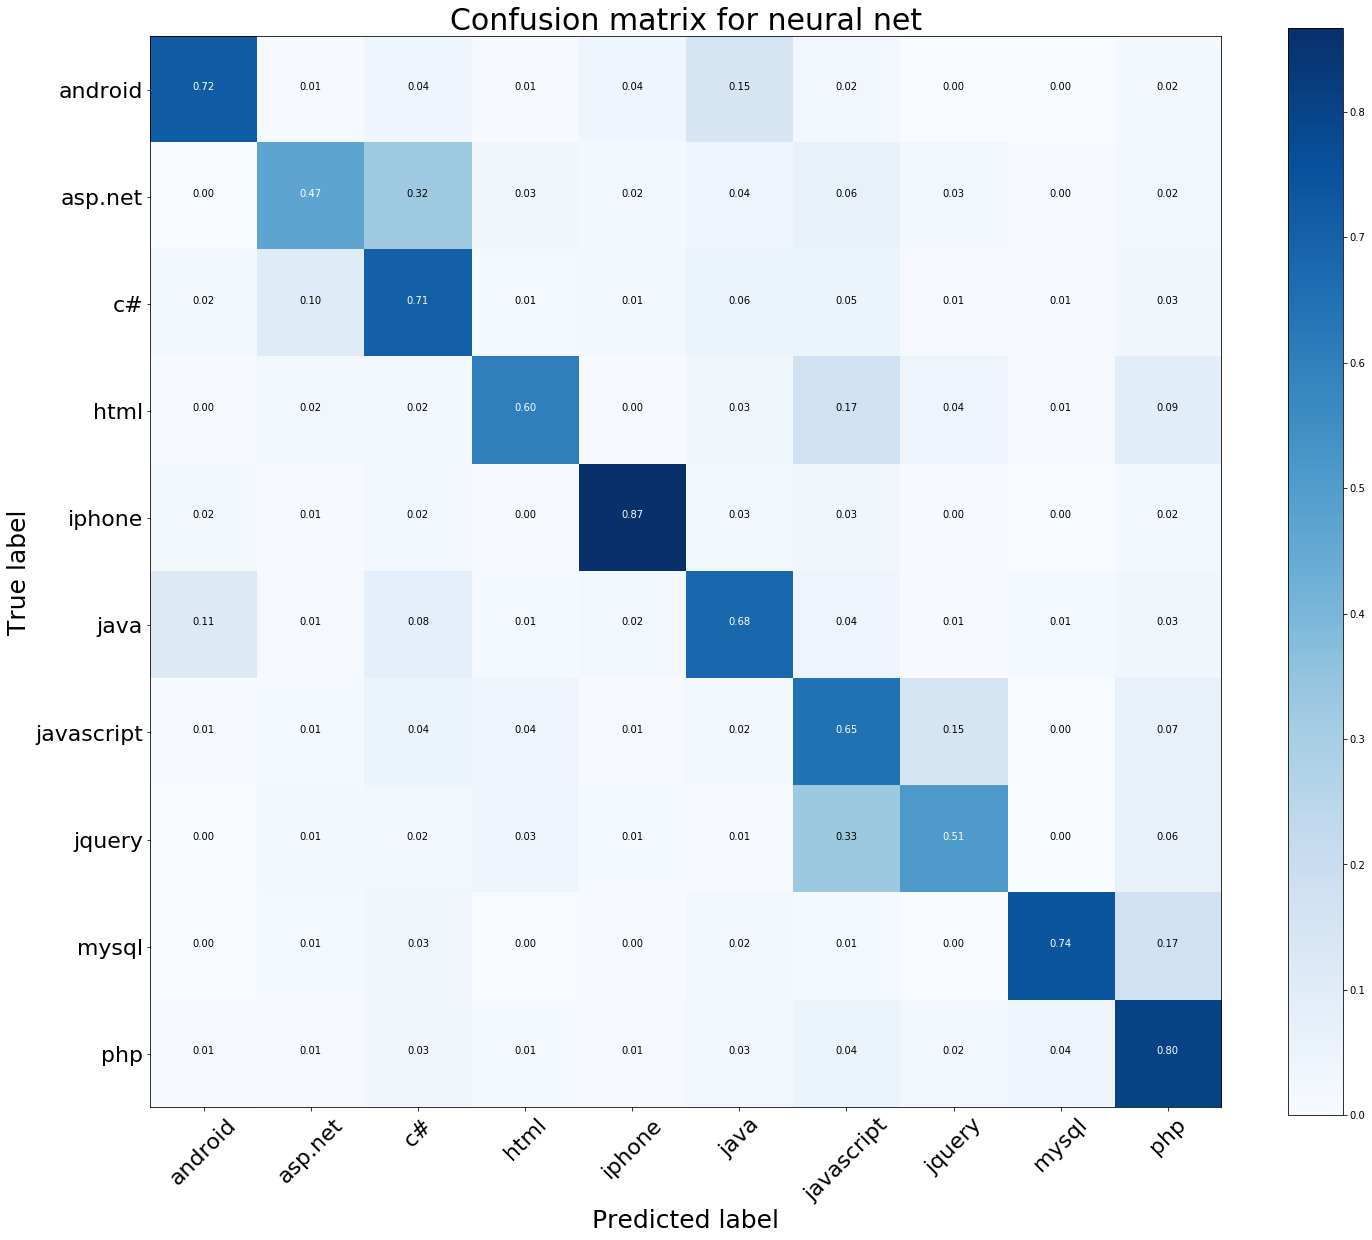

In [9]:
def predict_results_neural_net():
    y_test_1d, y_pred_1d = [], []
    y_softmax = neural_net.predict(x_test)

    for i in range(len(y_test)):
        probs = y_test[i]
        index_arr = np.nonzero(probs)
        one_hot_index = index_arr[0].item(0)
        y_test_1d.append(one_hot_index)

    for i in range(len(y_softmax)):
        probs = y_softmax[i]
        predicted_index = np.argmax(probs)
        y_pred_1d.append(predicted_index)
    return y_test_1d, y_pred_1d


y_test_1d, y_pred_1d = predict_results_neural_net()
cnf_matrix_neural_net = plot_cnf_from_predicts("Confusion matrix for neural net", text_labels, y_test_1d, y_pred_1d)

In [10]:
def save_neural_net():
    with open("neural_net.json", "w") as neural_net_json_file:
        neural_net_json_file.write(neural_net.to_json())
    neural_net.save_weights("neural_net.h5")

    with open('extras.pkl', 'wb') as extras:
        pickle.dump({
            'tokenize_title': tokenize_title,
            'tokenize_body': tokenize_body,
            'text_labels': text_labels,
            'encoder': encoder
        }, extras)

def load_neural_net():
    global tokenize_title, tokenize_body, text_labels, encoder
    with open('neural_net.json', 'r') as neural_net_json_file:
        neural_net = model_from_json(neural_net_json_file.read())
    neural_net.load_weights("neural_net.h5")

    with open('extras.pkl', 'rb') as extras:
        extra = pickle.load(extras)
    tokenize_title = extra['tokenize_title']
    tokenize_body = extra['tokenize_body']
    text_labels = extra['text_labels']
    encoder = extra['encoder']

def predict_single_tag_neural_net(data_title=None, data_body=None):
    if data_title is None:
        data_title = input('Enter title: ')
    if data_body is None:
        data_body = input('Enter body: ')

    tokenized_input = np.concatenate((tokenize_title.texts_to_matrix([data_title]), tokenize_body.texts_to_matrix([data_body])), axis=1)
    prediction = neural_net.predict(np.array(tokenized_input))
    predicted_tag = text_labels[np.argmax(prediction)]
    return predicted_tag


predict_single_tag_neural_net('', 'lifecycle of activity')

'java'

## using lsvm

In [11]:
x_train = train_posts.body.copy()
x_test = test_posts.body.copy()

y_train = train_posts.tags.copy()
y_test = test_posts.tags.copy()

In [12]:
%%time
linear_svm = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC(kernel='linear', verbose=True)),
])
linear_svm.fit(x_train, y_train)
y_pred_lsvm = linear_svm.predict(x_test)

print('accuracy {}'.format(accuracy_score(y_pred_lsvm, y_test)))
print(classification_report(y_test, y_pred_lsvm, target_names=text_labels))

[LibSVM]accuracy 0.6245430088983928
              precision    recall  f1-score   support

     android       0.83      0.68      0.75      2163
     asp.net       0.42      0.30      0.35       277
          c#       0.41      0.73      0.53      1489
        html       0.50      0.55      0.52       448
      iphone       0.74      0.76      0.75       795
        java       0.59      0.62      0.61      1712
  javascript       0.64      0.54      0.59      2688
      jquery       0.58      0.45      0.51      1551
       mysql       0.79      0.60      0.68       947
         php       0.68      0.73      0.71      2427

   micro avg       0.62      0.62      0.62     14497
   macro avg       0.62      0.60      0.60     14497
weighted avg       0.65      0.62      0.63     14497

CPU times: user 15min 4s, sys: 3.12 s, total: 15min 7s
Wall time: 15min 8s


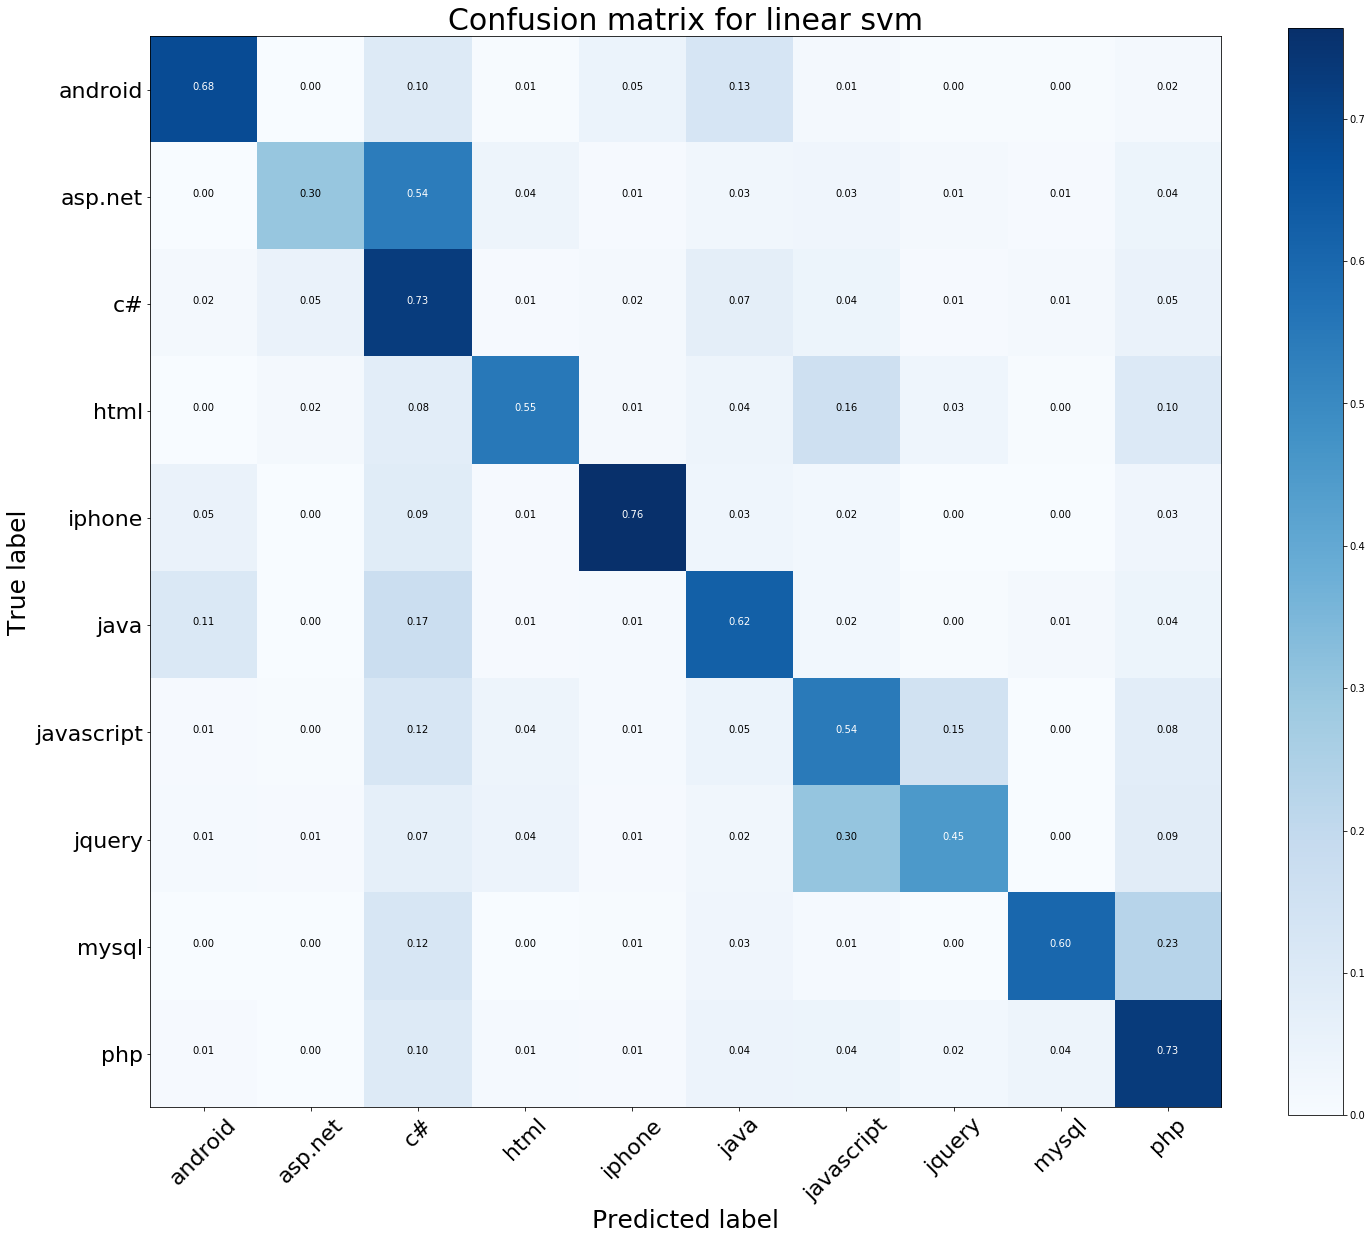

In [13]:
def predict_results_lsvm(y_pred_lsvm):
    y_test_1d, y_pred_1d = [], []

    labels = list(text_labels)
    for ytest, ypred in zip(y_test, y_pred_lsvm):
        y_test_1d.append(labels.index(ytest))
        y_pred_1d.append(labels.index(ypred))
    return y_test_1d, y_pred_1d


y_test_1d, y_pred_1d = predict_results_lsvm(y_pred_lsvm)
cnf_matrix_lsvm = plot_cnf_from_predicts("Confusion matrix for linear svm", text_labels, y_test_1d, y_pred_1d)

In [14]:
def save_lsvm():
    linear_svm_file = "linear_svm_model.pkl"
    joblib.dump(linear_svm, linear_svm_file)


def load_lsvm():
    linear_svm = joblib.load(linear_svm_file)

def predict_single_tag_linear_svm(data_title=None, data_body=None):
    if data_title is None:
        data_title = input('Enter title: ')
    if data_body is None:
        data_body = input('Enter body: ')
    return linear_svm.predict([data_body])[0]


predict_single_tag_linear_svm('', 'lifecycle of activity')

'android'

In [15]:
def plot_confusion_matrix_for_one_class(cm, classes, title, cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    
    
def summary_plot(cnf_matrix):
    total_sensitivity = np.array([np.array([0, 0]), np.array([0, 0])])
    cnf_total = cnf_matrix.sum()
    cnf_row = cnf_matrix.sum(axis=1)
    cnf_col = cnf_matrix.sum(axis=0)

    for i in range(len(text_labels)):
        tp = cnf_matrix[i][i]
        fn = cnf_row[i] - tp
        fp = cnf_col[i] - tp
        tn = cnf_total - (fn + fp + tp)
        total_sensitivity[0][0] += tp
        total_sensitivity[0][1] += fn
        total_sensitivity[1][0] += fp
        total_sensitivity[1][1] += tn
    plt.figure(figsize=(2,2))
    plot_confusion_matrix_for_one_class(total_sensitivity, classes=["true class", "non-true class"], title="Confusion matrix for overall")
    plt.show()

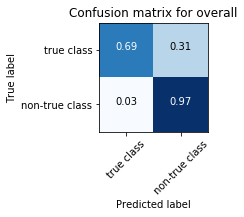

In [16]:
summary_plot(cnf_matrix_neural_net)

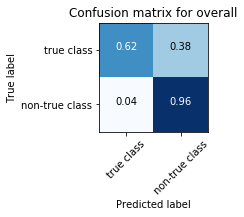

In [17]:
summary_plot(cnf_matrix_lsvm)

# some other algorithms
## using naive bayes

In [18]:
%%time

naive_bayes = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
naive_bayes.fit(x_train, y_train)
y_pred_nb = naive_bayes.predict(x_test)

print('accuracy of naive bayes: {}'.format(accuracy_score(y_pred_nb, y_test)))
print(classification_report(y_test, y_pred_nb, target_names=text_labels))

accuracy of naive bayes: 0.32337725046561355


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     android       0.94      0.04      0.07      2163
     asp.net       0.00      0.00      0.00       277
          c#       0.18      0.94      0.31      1489
        html       0.00      0.00      0.00       448
      iphone       0.96      0.21      0.35       795
        java       0.56      0.33      0.41      1712
  javascript       0.45      0.22      0.29      2688
      jquery       0.70      0.00      0.01      1551
       mysql       0.00      0.00      0.00       947
         php       0.44      0.78      0.56      2427

   micro avg       0.32      0.32      0.32     14497
   macro avg       0.42      0.25      0.20     14497
weighted avg       0.51      0.32      0.26     14497

CPU times: user 7.25 s, sys: 84.9 ms, total: 7.33 s
Wall time: 7.22 s


## using sdg

In [19]:
%%time

stochastic_gradient_descent = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)),
])
stochastic_gradient_descent.fit(x_train, y_train)
y_pred_sdg = stochastic_gradient_descent.predict(x_test)

print('accuracy of SDGClassifier: {}'.format(accuracy_score(y_pred_sdg, y_test)))
print(classification_report(y_test, y_pred_sdg, target_names=text_labels))

accuracy of SDGClassifier: 0.6587569842036284
              precision    recall  f1-score   support

     android       0.83      0.72      0.77      2163
     asp.net       0.40      0.42      0.41       277
          c#       0.49      0.72      0.58      1489
        html       0.57      0.55      0.56       448
      iphone       0.64      0.87      0.73       795
        java       0.65      0.64      0.65      1712
  javascript       0.69      0.55      0.61      2688
      jquery       0.58      0.54      0.56      1551
       mysql       0.79      0.64      0.71       947
         php       0.70      0.77      0.73      2427

   micro avg       0.66      0.66      0.66     14497
   macro avg       0.63      0.64      0.63     14497
weighted avg       0.67      0.66      0.66     14497

CPU times: user 8.76 s, sys: 10.8 ms, total: 8.77 s
Wall time: 8.77 s
